This is a simple example on how to predict COVID-19 spread using well-known Gradient Boosting Decision Trees libraries (CatBoost, LightGBM and XgBoost). 
The data to train on is taken from https://www.kaggle.com/c/covid19-global-forecasting-week-1/data.
For the sake of simplicity no extensive preprocessing and feature engineering is performed here. If you're interested in more comprehensive analysis of this data look at the Kaggle competition notebooks: https://www.kaggle.com/c/covid19-global-forecasting-week-1/notebooks.

Install and import necessary packages

In [2]:
!pip install kaggle

# install the latest versions of all GBDT packages

!pip install catboost -U
!pip install lightgbm -U
!pip install xgboost -U

import os
import pathlib

import numpy as np
import pandas as pd
import sklearn.preprocessing

import geopy.distance

import catboost as cb
import lightgbm as lgb
import xgboost as xgb

Requirement already up-to-date: catboost in /usr/local/lib/python3.6/dist-packages (0.22)
Requirement already up-to-date: lightgbm in /usr/local/lib/python3.6/dist-packages (2.3.1)
Requirement already up-to-date: xgboost in /usr/local/lib/python3.6/dist-packages (1.0.2)


As we download from Kaggle we need to provide Kaggle authetification cridentials. We will use the method suggested [here](https://gist.github.com/jayspeidell/d10b84b8d3da52df723beacc5b15cb27#gistcomment-2814834). Replace KAGGLE_USERNAME and KAGGLE_KEY with your own.

In [0]:
os.environ['KAGGLE_USERNAME'] = "XXX"
os.environ['KAGGLE_KEY'] = "YYY"

Let's download the data now.

In [4]:
kaggle_data_name = 'covid19-global-forecasting-week-1'
data_folder = os.path.join(pathlib.Path.home(), 'datasets', kaggle_data_name)

!mkdir -p ${data_folder}
!kaggle competitions download -c {kaggle_data_name} --path {data_folder}

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
submission.csv: Skipping, found more recently modified local copy (use --force to force download)


Let's check that data is ok.

In [5]:
!ls -l {data_folder}

total 1600
-rw-r--r-- 1 root root 111051 Mar 26 16:02 submission.csv
-rw-r--r-- 1 root root 552851 Mar 26 16:02 test.csv
-rw-r--r-- 1 root root 969831 Mar 26 16:02 train.csv


Let's load data to pandas.DataFrame.

In [6]:
df = pd.read_csv(os.path.join(data_folder,'train.csv'), parse_dates=['Date'])
df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


Let's preprocess input data and add some simple features:

1.   Add 'Day' feature that counts days from the start of the epidemic
2.   Add 'WeekDay' feature
3.   Add 'Distance_to_Hubei' feature. Hubei province of China is the original epicentre of the epidemic.


    
    


In [7]:
def get_hubei_coords(df):
    for index, row in df.iterrows():
        if row['Province/State'] == 'Hubei':
            return (row['Lat'], row['Long'])

    raise Exception('Hubei not found in data')

def preprocess(df):
    df = df.copy()
    df.drop(columns=['Id'], inplace=True)
    
    hubei_coords = get_hubei_coords(df)
    first_date = min(df['Date'])
    
    df.fillna({'Province/State': ''}, inplace=True)
    
    df['Day'] = (df['Date'] - first_date).dt.days.astype('int32')

    hubei_coords = get_hubei_coords(df)
    
    distance_to_hubei = []
    week_day = []
        
    for index, row in df.iterrows():
        distance_to_hubei.append(geopy.distance.distance((row['Lat'], row['Long']), hubei_coords).km)
        week_day.append(row['Date'].weekday())

    df['Distance_to_Hubei'] = distance_to_hubei
    df['WeekDay'] = week_day
    
    return df

preprocessed_df = preprocess(df)
preprocessed_df.head()

,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,Day,Distance_to_Hubei,WeekDay
0,,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,0,4435.232618,2
1,,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,1,4435.232618,3
2,,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,2,4435.232618,4
3,,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,3,4435.232618,5
4,,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,4,4435.232618,6


We will split data to train and test by date.

Labels are transformed to the logarithmic scale. Logarithmic scale is natural for this task (model should weight errors between 1000 and 1100 and 100000 and 110000 approximately the same).

We will use RMSE as an objective and evaluation metric for training, that will correspond to RMSLE (Root Mean Square Logarithmic Error) metric.

$$RMSLE(labels, predictions) = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{\Big(log(labels_i + 1) - log(predictions_i + 1)\Big)^2}}$$

For prediction values in the original scale model prediction output should be transformed back to the original scale with the reverse transformation (can be preformed using numpy.expm1 function).

In [0]:
last_train_date = pd.Timestamp(2020, 3, 11)

# returns train_features_df, train_labels, test_features_df, test_labels
def get_train_and_test_data(df):
    train_df = df[df['Date'] <= last_train_date].copy()
    test_df = df[df['Date'] > last_train_date].copy()
    
    train_df.sort_values(by=['Date'])
    train_labels = {
        'ConfirmedCases': np.log1p(train_df['ConfirmedCases']),
        'Fatalities': np.log1p(train_df['Fatalities'])
    }
    train_df.drop(columns=['ConfirmedCases', 'Fatalities', 'Date'], inplace=True)
    
    test_labels = {
        'ConfirmedCases': np.log1p(test_df['ConfirmedCases']),
        'Fatalities': np.log1p(test_df['Fatalities'])
    }
    test_df.drop(columns=['ConfirmedCases', 'Fatalities', 'Date'], inplace=True)
    
    return train_df, train_labels, test_df, test_labels



Categorical features

In [0]:
cat_features = ['Province/State', 'Country/Region', 'WeekDay']

We'll train models for 1000 iterations.


In [0]:
n_estimators = 1000

Let's train CatBoost first. Categorical features values can be used as is in DataFrame.


In [20]:
print ('catboost version', cb.__version__)

train_df, train_labels, test_df, test_labels = get_train_and_test_data(preprocessed_df)

catboost_models = {}
catboost_validation_errors = {}

for prediction_name in ['ConfirmedCases', 'Fatalities']:
    model = cb.CatBoostRegressor(
        loss_function='RMSE',  # RMSE with log1p-transformed labels is RMSLE
        eval_metric='RMSE',  # RMSE with log1p-transformed labels is RMSLE
        has_time=True,
        n_estimators=n_estimators
    )

    model.fit(
        train_df,
        train_labels[prediction_name],
        eval_set=(test_df, test_labels[prediction_name]),
        cat_features=cat_features
    )
    
    catboost_models[prediction_name] = model
    catboost_validation_errors[prediction_name] = model.evals_result_['validation']['RMSE'][-1]

catboost version 0.22
Learning rate set to 0.07608
0:	learn: 1.7234085	test: 3.5386691	best: 3.5386691 (0)	total: 16.5ms	remaining: 16.5s
1:	learn: 1.6429369	test: 3.4925579	best: 3.4925579 (1)	total: 31ms	remaining: 15.5s
2:	learn: 1.5809762	test: 3.4460454	best: 3.4460454 (2)	total: 39.4ms	remaining: 13.1s
3:	learn: 1.5126577	test: 3.4027039	best: 3.4027039 (3)	total: 55.3ms	remaining: 13.8s
4:	learn: 1.4366927	test: 3.3568337	best: 3.3568337 (4)	total: 70.2ms	remaining: 14s
5:	learn: 1.3837120	test: 3.3323965	best: 3.3323965 (5)	total: 85.2ms	remaining: 14.1s
6:	learn: 1.3335290	test: 3.3183975	best: 3.3183975 (6)	total: 98.7ms	remaining: 14s
7:	learn: 1.2809047	test: 3.2842091	best: 3.2842091 (7)	total: 111ms	remaining: 13.7s
8:	learn: 1.2123335	test: 3.2346071	best: 3.2346071 (8)	total: 121ms	remaining: 13.3s
9:	learn: 1.1507089	test: 3.1861818	best: 3.1861818 (9)	total: 132ms	remaining: 13.1s
10:	learn: 1.0912741	test: 3.1222808	best: 3.1222808 (10)	total: 142ms	remaining: 12.8s


Let's train LightGBM. Categorical features has to be transformed to integer values using enumeration.

In [21]:
# returns df, dict of cat_feature -> OrdinalEncoder
def preprocess_for_lightgbm(df, cat_features):
    df = df.copy()
    encoders = {}
    for cat_feature in cat_features:
        encoder = sklearn.preprocessing.OrdinalEncoder()
        df[cat_feature] = encoder.fit_transform([df[cat_feature]])[0]
        encoders[cat_feature] = encoder
        
    return df, encoders


print ('lightgbm version', lgb.__version__)

preprocessed_for_lighgbm_df, encoders = preprocess_for_lightgbm(preprocessed_df, cat_features)

train_df, train_labels, test_df, test_labels = get_train_and_test_data(preprocessed_for_lighgbm_df)

lightgbm_validation_errors = {}
lightgbm_models = {}

for prediction_name in ['ConfirmedCases', 'Fatalities']:
    model = lgb.LGBMRegressor(
        objective='rmse',  # RMSE with log1p-transformed labels is RMSLE
        metric='rmse',  # RMSE with log1p-transformed labels is RMSLE
        n_estimators=n_estimators,
    )

    model = model.fit(
        X=train_df,
        y=train_labels[prediction_name],
        categorical_feature=cat_features,
        eval_set=[(test_df, test_labels[prediction_name])],
    )

    lightgbm_models[prediction_name] = model
    lightgbm_validation_errors[prediction_name] = model.best_score_['valid_0']['rmse']


lightgbm version 2.3.1


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Country/Region', 'Province/State', 'WeekDay']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's rmse: 3.46743
[2]	valid_0's rmse: 3.36384
[3]	valid_0's rmse: 3.26514
[4]	valid_0's rmse: 3.18422
[5]	valid_0's rmse: 3.11768
[6]	valid_0's rmse: 3.04115
[7]	valid_0's rmse: 2.9904
[8]	valid_0's rmse: 2.9407
[9]	valid_0's rmse: 2.89437
[10]	valid_0's rmse: 2.8526
[11]	valid_0's rmse: 2.79566
[12]	valid_0's rmse: 2.74574
[13]	valid_0's rmse: 2.71452
[14]	valid_0's rmse: 2.6747
[15]	valid_0's rmse: 2.63919
[16]	valid_0's rmse: 2.61281
[17]	valid_0's rmse: 2.58872
[18]	valid_0's rmse: 2.56302
[19]	valid_0's rmse: 2.52527
[20]	valid_0's rmse: 2.50188
[21]	valid_0's rmse: 2.47681
[22]	valid_0's rmse: 2.46273
[23]	valid_0's rmse: 2.44648
[24]	valid_0's rmse: 2.42089
[25]	valid_0's rmse: 2.40718
[26]	valid_0's rmse: 2.392
[27]	valid_0's rmse: 2.37849
[28]	valid_0's rmse: 2.36117
[29]	valid_0's rmse: 2.34847
[30]	valid_0's rmse: 2.33332
[31]	valid_0's rmse: 2.30642
[32]	valid_0's rmse: 2.29609
[33]	valid_0's rmse: 2.29222
[34]	valid_0's rmse: 2.27425
[35]	valid_0's rmse: 2.2542
[

And the third GBDT package is XgBoost. XgBoost does not support categorical features out of the box, so we will transform original categorical features to one-hot features.

In [22]:
# returns df, dict of cat_feature -> OneHotEncoder
def preprocess_for_xgboost(df, cat_features):
    df = df.copy()
    encoders = {}
    for cat_feature in cat_features:
        # xgboost doesn't support sparse columns in pandas.DataFrame input
        encoder = sklearn.preprocessing.OneHotEncoder(dtype=np.bool, sparse=False)

        ohe_matrix = encoder.fit_transform(df[cat_feature].to_numpy().reshape(-1, 1))
        ohe_df = pd.DataFrame(
            ohe_matrix,
            columns=encoder.get_feature_names([cat_feature])
        )
        df = pd.concat([df, ohe_df], axis=1)
        df.drop(cat_feature, axis=1, inplace=True)

        encoders[cat_feature] = encoder

    return df, encoders



print ('xgboost version', xgb.__version__)

preprocessed_for_xgboost_df, encoders = preprocess_for_xgboost(preprocessed_df, cat_features)

train_df, train_labels, test_df, test_labels = get_train_and_test_data(preprocessed_for_xgboost_df)

xgboost_validation_errors = {}
xgboost_models = {}

for prediction_name in ['ConfirmedCases', 'Fatalities']:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',  # RMSE with log1p-transformed labels is RMSLE
        eval_metric='rmse',  # RMSE with log1p-transformed labels is RMSLE
        n_estimators=n_estimators,
    )

    model = model.fit(
        X=train_df,
        y=train_labels[prediction_name],
        eval_set=[(test_df, test_labels[prediction_name])]
    )

    xgboost_models[prediction_name] = model
    xgboost_validation_errors[prediction_name] = model.evals_result()['validation_0']['rmse'][-1]

xgboost version 1.0.2
[0]	validation_0-rmse:3.40985
[1]	validation_0-rmse:3.09217
[2]	validation_0-rmse:2.87419
[3]	validation_0-rmse:2.77975
[4]	validation_0-rmse:2.63987
[5]	validation_0-rmse:2.61278
[6]	validation_0-rmse:2.57490
[7]	validation_0-rmse:2.43446
[8]	validation_0-rmse:2.40905
[9]	validation_0-rmse:2.40070
[10]	validation_0-rmse:2.33275
[11]	validation_0-rmse:2.32340
[12]	validation_0-rmse:2.22487
[13]	validation_0-rmse:2.21482
[14]	validation_0-rmse:2.20855
[15]	validation_0-rmse:2.19960
[16]	validation_0-rmse:2.19803
[17]	validation_0-rmse:2.18790
[18]	validation_0-rmse:2.18506
[19]	validation_0-rmse:2.18173
[20]	validation_0-rmse:2.14014
[21]	validation_0-rmse:2.13472
[22]	validation_0-rmse:2.13166
[23]	validation_0-rmse:2.13350
[24]	validation_0-rmse:2.12342
[25]	validation_0-rmse:2.12134
[26]	validation_0-rmse:2.11790
[27]	validation_0-rmse:2.11492
[28]	validation_0-rmse:2.11134
[29]	validation_0-rmse:2.10985
[30]	validation_0-rmse:2.08948
[31]	validation_0-rmse:2.08

Let's compare RMSLE error on test for all GBDT implementations.

In [23]:
for prediction_name in ['ConfirmedCases', 'Fatalities']:
    print ('CatBoost: prediction of %s: RMSLE on test = %s' % (prediction_name, catboost_validation_errors[prediction_name]))
    print ('LightGBM: prediction of %s: RMSLE on test = %s' % (prediction_name, lightgbm_validation_errors[prediction_name]))
    print ('XgBoost: prediction of %s: RMSLE on test = %s' % (prediction_name, xgboost_validation_errors[prediction_name]))

CatBoost: prediction of ConfirmedCases: RMSLE on test = 1.7130733010288208
LightGBM: prediction of ConfirmedCases: RMSLE on test = 1.8080456616778966
XgBoost: prediction of ConfirmedCases: RMSLE on test = 1.785172
CatBoost: prediction of Fatalities: RMSLE on test = 0.7938150681857505
LightGBM: prediction of Fatalities: RMSLE on test = 0.8112365813255957
XgBoost: prediction of Fatalities: RMSLE on test = 0.798991


Let's look at feature importances.
For CatBoost use [PredictionValuesChange](https://catboost.ai/docs/concepts/fstr.html#fstr__regular-feature-importance).

In [24]:
for prediction_name in ['ConfirmedCases', 'Fatalities']:
    print ('\nCatBoost: prediction of %s. Feature importance. Type=PredictionValuesChange' % prediction_name)
    print (catboost_models[prediction_name].get_feature_importance(type=cb.EFstrType.PredictionValuesChange, prettified=True))


CatBoost: prediction of ConfirmedCases. Feature importance. Type=PredictionValuesChange
          Feature Id  Importances
0  Distance_to_Hubei    34.660626
1     Country/Region    17.132457
2     Province/State    16.414815
3                Day    13.621041
4                Lat     9.746912
5               Long     6.513599
6            WeekDay     1.910550

CatBoost: prediction of Fatalities. Feature importance. Type=PredictionValuesChange
          Feature Id  Importances
0     Province/State    49.637990
1  Distance_to_Hubei    14.761734
2     Country/Region    12.875072
3               Long    10.726166
4                Lat     5.548307
5                Day     4.907931
6            WeekDay     1.542799


Let's look at LightGBM models' feature importances. 
1. "split” means result contains numbers of times the feature is used in a model. 
2. “gain” means result contains total gains of splits which use the feature.

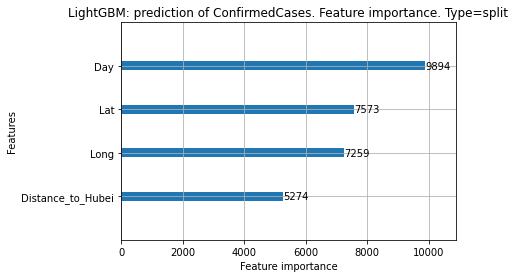

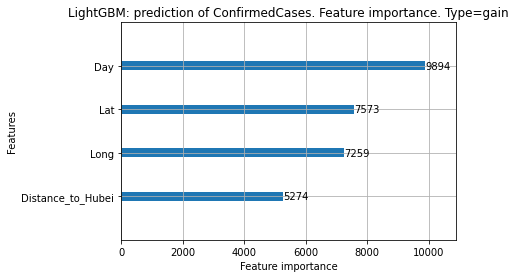

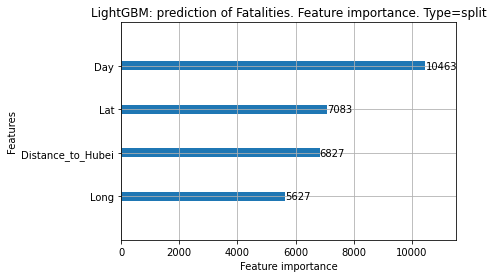

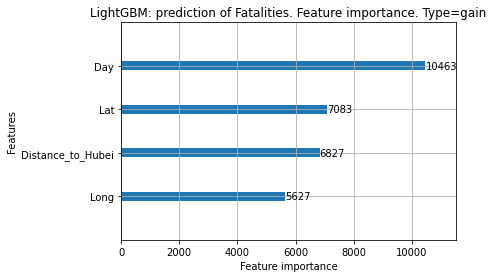

In [25]:
for prediction_name in ['ConfirmedCases', 'Fatalities']:
    for importance_type in ['split', 'gain']:
        lgb.plot_importance(lightgbm_models[prediction_name], title='LightGBM: prediction of %s. Feature importance. Type=%s' % (prediction_name, importance_type))

Let's look at XgBoost models' feature importances.

1. "split” means result contains numbers of times the feature is used in a model.
2. “gain” means result contains total gains of splits which use the feature.
3. ”cover” means result is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split



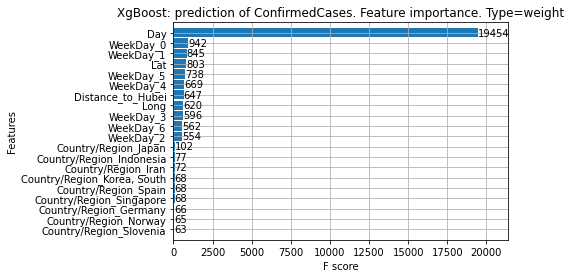

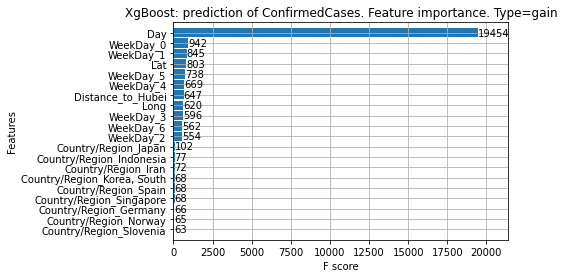

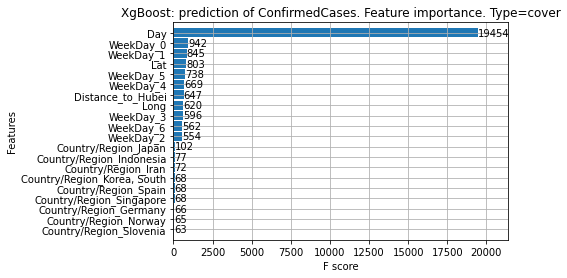

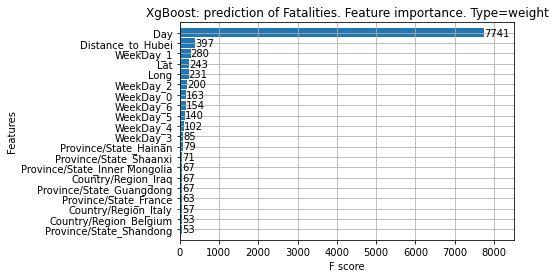

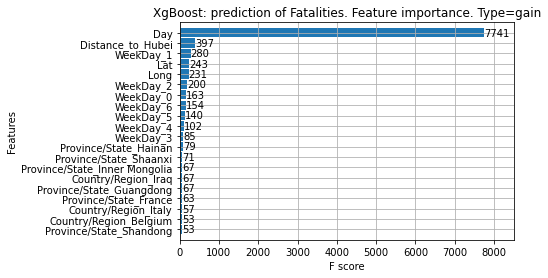

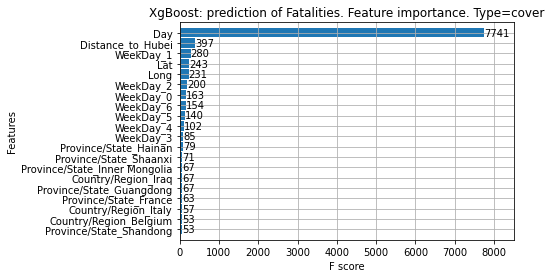

In [26]:
for prediction_name in ['ConfirmedCases', 'Fatalities']:
    for importance_type in ['weight', 'gain', 'cover']:
        xgb.plot_importance(
            xgboost_models[prediction_name],
            title='XgBoost: prediction of %s. Feature importance. Type=%s' % (prediction_name, importance_type),
            height=0.9,
            max_num_features=20
        )
